In [1]:
# This notebook also requires dask, xarray, matplotlib

import numpy as np
from oceanmixedlayers import oceanmixedlayers
import matplotlib.pyplot as plt

import gsw as gsw
import xarray as xr
from glob import glob

import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

def IsVarThere(hndl,VAR):
    CHECK = [A for A in hndl.data_vars  if A==VAR]
    return len(CHECK)>0

In [2]:
Argo_path = '/net3/bgr/Datasets/Argo/202011-ArgoData/dac/'


profile_paths = glob(Argo_path+'*/*/*_prof.nc')

LP = len(profile_paths)

print(LP,'total Argo files to parse')

# TP=0
# for IN in range(LP):
#     if np.mod(IN,10)==0: print("Computing total profiles, file: "+str(IN)+'/'+str(LP), end = "\r")
#     with xr.open_dataset(profile_paths[IN]) as hndl:
#         TP+=hndl.N_PROF.size
        
# print(TP,'total Argo profiles')

7502 total Argo files to parse


In [3]:
def mld_dataset(LP):
        OUT = xr.Dataset(data_vars={'mld':(('prof'), np.add(np.NaN,np.zeros([LP]))),
                                    'pe_anom':(('prof'), np.add(np.NaN,np.zeros([LP]))),
                                    'latitude':(('prof'), np.add(np.NaN,np.zeros([LP]))),
                                    'longitude':(('prof'), np.add(np.NaN,np.zeros([LP]))),
                                    'julian_day':(('prof'), np.add(np.NaN,np.zeros([LP]))),
                                    'file':(''),
                                    'dac':(''),
                                    'argo_id':(''),
                                   },
                            coords={'prof': range(LP),}
                        )
        return OUT

In [69]:
odir = '/net3/bgr/Datasets/Argo/MLDs/'

#Choices are: 

BATCH=[0,LP]
TP=0
for IN in range(BATCH[0],BATCH[1]):
    
    with xr.open_dataset(profile_paths[IN]) as hndl:
        
        if ( (IsVarThere(hndl,'TEMP'))&(IsVarThere(hndl,'PSAL'))):

            NP = hndl.N_PROF.size
            NZ = hndl.N_LEVELS.size
            Z_c_2d       = np.zeros([NP,NZ])+np.NaN
            dZ_2d        = np.zeros([NP,NZ])+np.NaN
            P_c_2d       = np.zeros([NP,NZ])+np.NaN
            dP_2d        = np.zeros([NP,NZ])+np.NaN
            CT_c_2d      = np.zeros([NP,NZ])+np.NaN
            PSal_c_2d    = np.zeros([NP,NZ])+np.NaN
            dRho0dz_c_2d = np.zeros([NP,NZ])+np.NaN
            Rho0_c_2d    = np.zeros([NP,NZ])+np.NaN
            Rho_c_2d    = np.zeros([NP,NZ])+np.NaN
            GOOD         = np.zeros([NP],dtype=bool)
            for p in range(NP):
                DayQC = float(hndl.JULD_QC[p])
                PosQC = float(hndl.POSITION_QC[p])
                if (np.max(DayQC==np.array([1,2,5,8]))
                    and 
                    np.max(PosQC==np.array([1,2,5,8]))):

                    #QC
                    SALTQC = np.array(hndl.PSAL_QC[p,:],dtype=float)
                    TEMPQC = np.array(hndl.TEMP_QC[p,:],dtype=float)
                    PRESQC = np.array(hndl.PRES_QC[p,:],dtype=float)

                    #Computes in-situ density from T&S, T, or S

                    #Start with some quality control on the data
                    LI = (((SALTQC==1)|(SALTQC==2)|(SALTQC==5)|(SALTQC==8))
                          &
                          ((TEMPQC==1)|(TEMPQC==2)|(TEMPQC==5)|(TEMPQC==8))
                          &
                          ((PRESQC==1)|(PRESQC==2)|(PRESQC==5)|(PRESQC==8)))
                    if (np.sum(LI)>20):
                        Pressure = np.array(hndl.PRES[p,:][LI],dtype=float)
                        PSal = np.array(hndl.PSAL[p,:].values[LI],dtype=float)
                        Temp = np.array(hndl.TEMP[p,:].values[LI],dtype=float)

                        QQ = ((np.min(Pressure)>0)&(np.max(Pressure)<3000)&
                              (np.min(PSal)>0)&(np.max(PSal)<50)&
                              (np.min(Temp)>-2)&(np.max(Temp)<50))
                        QS = all(Pressure[z] < Pressure[z+1] for z in range(len(Pressure)-1))
                        if (QQ and QS):
                            GOOD[p]=True
                        else:
                            GOOD[p]=False
                    else:
                        GOOD[p]=False

                    if GOOD[p]:
                        Rho = gsw.density.rho_t_exact(PSal,Temp,Pressure)
                        CT = gsw.conversions.CT_from_rho(Rho,PSal,Pressure)[0]
                        Rho0 = gsw.density.rho(PSal,CT,0)

                        #Set a zero surface pressure bin
                        P_i = np.array([0.]+list(Pressure))

                        #First guess at Z_i from pressure
                        Z_i = -1.*P_i
                        dZ = (Z_i[:-1]-Z_i[1:])

                        if (np.min(dZ)<=0 or np.max(dZ)>100):
                            GOOD[p]=False
                        else:
                            CT_i = np.array([CT[0]]+list(CT))
                            PSal_i = np.array([PSal[0]]+list(PSal))
                            Rho0_i = np.array([Rho0[0]]+list(Rho0))

                            P_c       = 0.5*(P_i[1:]+P_i[:-1])
                            dP        = (P_i[:-1]-P_i[1:])
                            CT_c      = 0.5*(CT_i[1:]+CT_i[:-1])
                            PSal_c    = 0.5*(PSal_i[1:]+PSal_i[:-1])
                            Rho0_c    = 0.5*(Rho0_i[1:]+Rho0_i[:-1])
                            dRho0dz_c = (Rho0_i[...,:-1]-Rho0_i[...,1:])/dZ

                            #Get density for layer from mean CT and Psal and central pressure
                            Rho = gsw.density.rho(PSal,CT_c,P_c)
                            #Compute Z_i referenced to a z=0 surface using layer mean density
                            # and assuming hydrostatic pressure
                            for zi in range(len(Rho)):
                                Z_i[zi+1]=Z_i[zi]+1.e4*dP[zi]/(9.81*Rho[zi])
                            Z_c = 0.5*(Z_i[1:]+Z_i[:-1])
                            dZ = (Z_i[:-1]-Z_i[1:])

                            LG = len(Z_c)
                            Energy = 25/9.81
                            Rho_c_2d[p,:LG] = Rho
                            CT_c_2d[p,:LG] = CT_c
                            PSal_c_2d[p,:LG] = PSal_c
                            P_c_2d[p,:LG] = P_c
                            Z_c_2d[p,:LG] = Z_c
                            dRho0dz_c_2d[p,:LG] = dRho0dz_c
                            Rho0_c_2d[p,:LG] = Rho0_c
                            dZ_2d[p,:LG] = dZ
                            dP_2d[p,:LG] = dP
            
            if np.sum(GOOD)>0:
                
                for Option in [1,3,4,5]:

                    #/Choices-----------------------------------------------------------------------
                    #
                    # Option 1
                    if Option==1:
                        method='prho_threshold_003'  # potential density threshold w/ 0.03 criteria
                        print('\r',"file: "+str(IN)+'/'+str(LP),'profs=',TP,
                              method,' '*80,end='')
                    # Option 2
                    if Option==2:
                        method='holtetalley'         # holte talley algorithm method
                        print('\r',"file: "+str(IN)+'/'+str(LP),'profs=',TP,
                              method,' '*80,end='')
                    # Option 3
                    if Option==3:
                        method='pe_anomaly'          # pe anomaly
                        energy = 10 # J/m2
                        gradient=True
                        print('\r',"file: "+str(IN)+'/'+str(LP),'profs=',TP,
                              method,'with gradient and e=',energy,' '*80,end=' ')
                    # Option 4
                    if Option==4:
                        method='pe_anomaly'          # pe anomaly
                        energy = 10 # J/m2
                        gradient=False
                        print('\r',"file: "+str(IN)+'/'+str(LP),'profs=',TP,
                              method,'with e=',energy,' '*80,end='')
                    #Option 5
                    if Option==5:
                        method='delta_pe'            # delta pe
                        energy = 10 # J/m2
                        print('\r',"file: "+str(IN)+'/'+str(LP),'profs=',TP,
                              method,'with e=',energy,' '*80,end='')
                    #-----------------------------------------------------------------------------

     
                    if method == 'prho_threshold_003':
                        LBL = method
                        MLD,_ = oceanmixedlayers.threshold(P_c_2d[GOOD,:].T,
                                                           Rho0_c_2d[GOOD,:].T,
                                                           delta=0.03,
                                                           ref=10
                                                          )
                    elif method == 'holtetalley':
                        LBL = method
                        OUT = oceanmixedlayers.holtetalley(P_c_2d[GOOD,:].T,
                                                           PSal_c_2d[GOOD,:].T,
                                                           CT_c_2d[GOOD,:].T,
                                                           Rho0_c_2d[GOOD,:].T)
                        MLD_p=OUT[2] #This is in pressure
                        MLD = np.zeros(np.shape(MLD_p))
                        DP = np.zeros(np.shape(MLD_p))
                        for ii in range(NZ):
                            li = DP<MLD_p
                            Pfrac_togo = (MLD_p-DP)/-dP_2d[GOOD,ii]
                            DP+=-dP_2d[GOOD,ii]
                            lf = DP>MLD_p

                            MLD[(li)&(~lf)]+=dZ_2d[GOOD,ii][(li)&(~lf)]
                            MLD[(li)&(lf)]+=(dZ_2d[GOOD,ii]*Pfrac_togo)[(li)&(lf)]

                    elif method == 'pe_anomaly':
                        if gradient == True: 
                            LBL=method+'_grad'+str(energy)
                        else:
                            LBL = method+'_'+str(energy)

                        MLD = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                                              dZ_2d[GOOD,:].T,
                                                              Rho0_c_2d[GOOD,:].T,
                                                              dRho0dz_c_2d[GOOD,:].T,
                                                              energy=energy,
                                                              gradient=gradient
                                                             )
                    elif method=='delta_pe':
                        LBL = method+'_'+str(energy)
                        MLD = oceanmixedlayers.mld_delta_pe(P_c_2d[GOOD,:].T,
                                                      dP_2d[GOOD,:].T,
                                                      CT_c_2d[GOOD,:].T,
                                                      PSal_c_2d[GOOD,:].T,
                                                      energy=energy,
                                                     )
                    
                    pe_anom = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                                          dZ_2d[GOOD,:].T,
                                                          Rho0_c_2d[GOOD,:].T,
                                                          dRho0dz_c_2d[GOOD,:].T,
                                                          depth=-MLD,
                                                          gradient=True
                                                         )
                    
                    file = profile_paths[IN].split('/')[-1]
                    argo_id = profile_paths[IN].split('/')[-2]
                    dac = profile_paths[IN].split('/')[-3]

                    out = mld_dataset(NP)

                    out.mld[GOOD]     = MLD
                    out.pe_anom[GOOD] = pe_anom
                    out.latitude[:]   = hndl.LATITUDE
                    out.longitude[:]  = hndl.LONGITUDE
                    out.julian_day[:] = hndl.JULD
                    out['file']       = file
                    out['argo_id']    = argo_id
                    out['dac']        = dac

                    filename = odir+'/'+dac+'/'+argo_id+'/'+'mld_'+LBL+'.nc'
                    if not os.path.exists(os.path.dirname(filename)):
                        os.makedirs(os.path.dirname(filename))

                    out.to_netcdf(filename,encoding={
                        'mld': {'_FillValue': -9999},
                        'pe_anom': {'_FillValue': -9999},
                                })
                TP+=np.sum(GOOD)
                                 

 file: 7501/7502 profs= 374899 delta_pe with e= 10                                                                                                 file: 7486/7502 profs= 374816 pe_anomaly with e= 10                                                                                 

[21.74765064]



 prho_threshold_003
prho_threshold_003
0

 pe_anomaly with gradient and e= 10
pe_anomaly_grad10
0

 pe_anomaly with e= 10
pe_anomaly_10
0

 delta_pe with e= 10
delta_pe_10
0


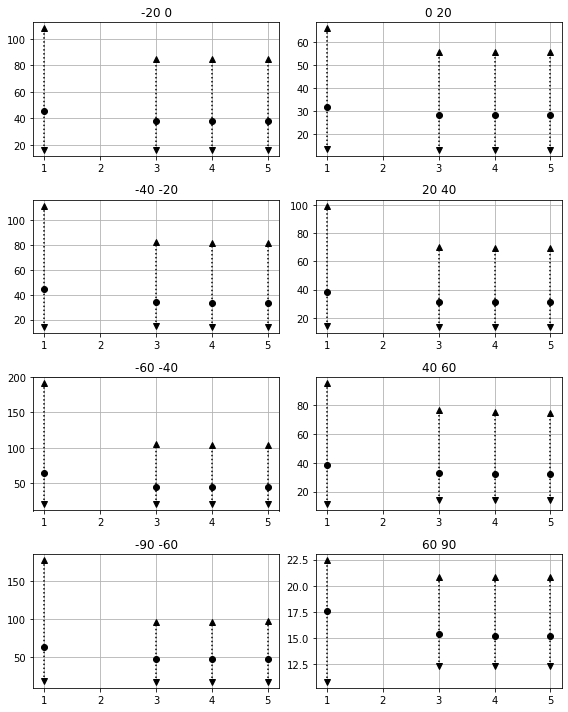

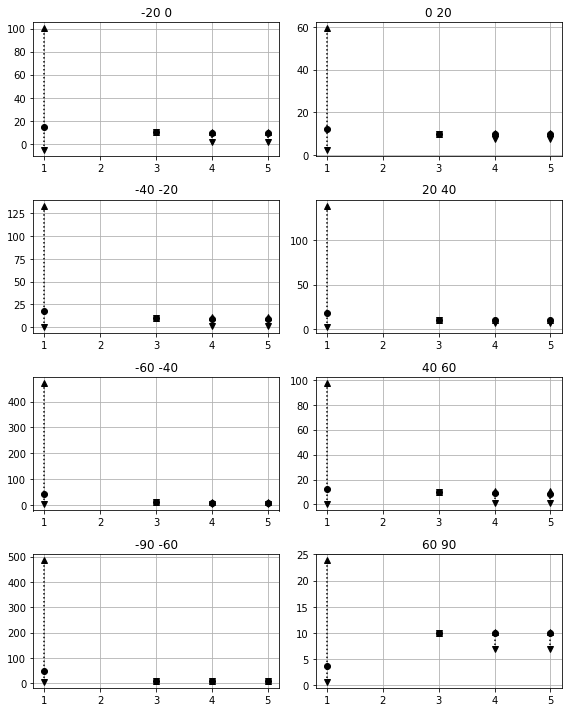

In [73]:
root = '/net3/bgr/Datasets/Argo/MLDs/'

f,a=plt.subplots(4,2,figsize=(8,10))
f2,a2=plt.subplots(4,2,figsize=(8,10))
    
LBLs=[]
for Option in [1,3,4,5]:

    #/Choices-----------------------------------------------------------------------
    #
    # Option 1
    if Option==1:
        method='prho_threshold_003'  # potential density threshold w/ 0.03 criteria
        print('\n',method)
    # Option 2
    if Option==2:
        method='holtetalley'         # holte talley algorithm method
        print('\n',method)
    # Option 3
    if Option==3:
        method='pe_anomaly'          # pe anomaly
        energy = 10 # J/m2
        gradient=True
        print('\n',method,'with gradient and e=',energy)
    # Option 4
    if Option==4:
        method='pe_anomaly'          # pe anomaly
        energy = 10 # J/m2
        gradient=False
        print('\n',method,'with e=',energy)
    #Option 5
    if Option==5:
        method='delta_pe'            # delta pe
        energy = 10 # J/m2
        print('\n',method,'with e=',energy)
    #-----------------------------------------------------------------------------

    if method == 'prho_threshold_003':
        LBL = method
    elif method == 'holtetalley':
        LBL = method
    elif method == 'pe_anomaly':
        if gradient == True: 
            LBL=method+'_grad'+str(energy)
        else:
            LBL = method+'_'+str(energy)
    elif method=='delta_pe':
        LBL = method+'_'+str(energy)
    print(LBL)
    files = glob(root+'/*/*/*'+LBL+'.nc')
    
    mld=[]
    pe=[]
    lat=[]
    for ii in range(len(files[:100])):
        if (np.mod(ii,100)==0): print(ii)
        mld=np.array(list(mld)+list(xr.open_dataset(files[ii]).mld))
        pe=np.array(list(pe)+list(xr.open_dataset(files[ii]).pe_anom))
        lat=np.array(list(lat)+list(xr.open_dataset(files[ii]).latitude))
    
    pct_range = [10,90]
    
    grps=[[60,90],
          [40,60],
          [20,40],
          [0,20],
          ]
    
    
    fi=4
    for grp_ in grps:
        fi-=1
        col=2
        for grp in [grp_,-np.array(grp_)[::-1]]:
            col-=1
            
            ax=a[fi,col]
            ax.plot(Option,np.nanpercentile(mld[(lat>grp[0])&(lat<grp[1])],pct_range[0]),'kv')
            ax.plot(Option,np.nanpercentile(mld[(lat>grp[0])&(lat<grp[1])],50),'ko')
            ax.plot(Option,np.nanpercentile(mld[(lat>grp[0])&(lat<grp[1])],pct_range[1]),'k^')
            ax.plot([Option,Option],
                     [np.nanpercentile(mld[(lat>grp[0])&(lat<grp[1])],pct_range[0]),
                      np.nanpercentile(mld[(lat>grp[0])&(lat<grp[1])],pct_range[1])],'k:')
            ax.grid(True)
            ax.set_title(str(grp[0])+' '+str(grp[1]))
            
            ax=a2[fi,col]
            ax.plot(Option,np.nanpercentile(pe[(lat>grp[0])&(lat<grp[1])],pct_range[0]),'kv')
            ax.plot(Option,np.nanpercentile(pe[(lat>grp[0])&(lat<grp[1])],50),'ko')
            ax.plot(Option,np.nanpercentile(pe[(lat>grp[0])&(lat<grp[1])],pct_range[1]),'k^')
            ax.plot([Option,Option],
                     [np.nanpercentile(pe[(lat>grp[0])&(lat<grp[1])],pct_range[0]),
                      np.nanpercentile(pe[(lat>grp[0])&(lat<grp[1])],pct_range[1])],'k:')
            ax.grid(True)
            ax.set_title(str(grp[0])+' '+str(grp[1]))
f.tight_layout()
f2.tight_layout()

In [10]:
print(hndl)

<xarray.Dataset>
Dimensions:                       (N_PROF: 13, N_PARAM: 3, N_LEVELS: 1007, N_CALIB: 1, N_HISTORY: 0)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB, N_HISTORY
Data variables: (12/64)
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    ...                            ...
    HISTORY_ACTION                (N_HISTORY, N_PROF) object ...
    HISTORY_PARAMETER             (N_HISTORY, N_PROF) object ...
    HISTORY_START_PRES            (N_HISTORY, N_PROF) float32 ...
    HISTORY_STOP_PRES             (N_HISTORY, N_PROF) float32 ...
    HISTORY_PREVIOUS_VALUE        (N_HISTORY, N_PROF) float32 ...
    HISTORY_QCTEST                (N_HISTORY, N_PROF) object ...
Attributes:
    title:                Argo float vertical profile
    institut